# Triathlon Recommender System by Todd Dole

Triathlon Recommender System
By Todd Dole

# Part 2

In [1]:
!pip install --upgrade pandas numpy matplotlib seaborn scikit-learn nltk scipy scikit-surprise

  Using cached numpy-2.0.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)


In [45]:
import os; os.environ['OPENBLAS_NUM_THREADS']='1'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import implicit
from sklearn.model_selection import train_test_split
import threadpoolctl
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from collections import defaultdict
from itertools import product

# Next Part of Project

We are going to build a second recommender system using a user's best performance on each course (as a percentile of finish place within age group.)

The idea here is that courses where an athlete performs better are rated higher, while courses where an athlete performs worse are rated lower.

We will scale each athlete's finishes from -1 to 1, so that courses they have never raced on will be treated the same as the courses exactly in the middle of their own personal results.


In [27]:
merged_df = pd.read_csv('data/merged_triathlon_data_with_percentiles.csv')

# Let's pick the best percentile score for each course, and then normalize the results

In [29]:
# Calculate min and max percentile scores for each user for each course
best_percentile_scores = merged_df.groupby(['course_id', 'person_id'])['percentile'].max().reset_index(name='best_percentile_scores')

# Calculate min and max for each user
best_percentile_scores['min_percentile'] = best_percentile_scores.groupby('person_id')['best_percentile_scores'].transform('min')
best_percentile_scores['max_percentile'] = best_percentile_scores.groupby('person_id')['best_percentile_scores'].transform('max')

# Apply min-max normalization to scale scores from -1 to 1
best_percentile_scores['normalized_percentile'] = 2 * (best_percentile_scores['best_percentile_scores'] - best_percentile_scores['min_percentile']) / (best_percentile_scores['max_percentile'] - best_percentile_scores['min_percentile']) - 1

# Handle cases where min and max are the same by setting normalized_percentile to 0
best_percentile_scores['normalized_percentile'] = best_percentile_scores['normalized_percentile'].replace([np.inf, -np.inf], 0).fillna(0)

# Select only the required columns for the recommender system
recommender_data = best_percentile_scores[['course_id', 'person_id', 'normalized_percentile']]

# Display the new dataframe
print(recommender_data)

# Optionally, save the new dataframe to a CSV file
recommender_data.to_csv('data/course_person_normalized_percentile_scores.csv', index=False)



         course_id  person_id  normalized_percentile
0                0          5              -1.000000
1                0        104               0.762948
2                0        109              -0.301075
3                0        129               0.292518
4                0        130              -0.325472
...            ...        ...                    ...
2351094       2223     854639               0.000000
2351095       2223     854640               0.000000
2351096       2223     854641               0.000000
2351097       2223     854642               0.000000
2351098       2223     854643               0.000000

[2351099 rows x 3 columns]


# Double checking to make sure there aren't any nan values in the data set

In [30]:
# Check for NaN values in the data
print(recommender_data.isna().sum())

# Drop rows with NaN values if any
recommender_data = recommender_data.dropna()


course_id                0
person_id                0
normalized_percentile    0
dtype: int64


# Let's get the data ready for our model

In [31]:
# Prepare data for Surprise library using normalized percentiles
reader = Reader(rating_scale=(recommender_data['normalized_percentile'].min(), recommender_data['normalized_percentile'].max()))
print(recommender_data['normalized_percentile'].min())
print(recommender_data['normalized_percentile'].max())

performance_dataset = Dataset.load_from_df(recommender_data[['person_id', 'course_id', 'normalized_percentile']], reader)


-1.0
1.0


# Do an initial build and fit, and see how we perform

In [32]:
# Split the dataset into training and testing sets
trainset, testset = train_test_split(performance_dataset, test_size=0.2, random_state=42)

# Train the collaborative filtering model using SVD

performance_algo = SVD()
performance_algo.fit(trainset)

# Evaluate the algorithm on the testset
predictions = performance_algo.test(testset)

# Compute and print RMSE
accuracy.rmse(predictions)


RMSE: 0.7299


0.7298712220449883

# Let's test the model and see what courses it recommends for me

In [36]:
# Load the CSV file
course_id_to_identifier_df = pd.read_csv('data/course_id_to_identifier.csv')

# Convert the DataFrame to a dictionary
course_id_to_identifier = pd.Series(course_id_to_identifier_df.course_identifier.values, index=course_id_to_identifier_df.course_id).to_dict()

def recommend_courses_based_on_performance(user_id, algo, trainset, course_id_to_identifier, n=5):
       
    # Check if the user exists in the trainset
    if trainset.knows_user(user_id):
        inner_uid = trainset.to_inner_uid(user_id)
        known_user = True
    else:
        print(f"User ID {user_id} not found in training data. Providing fallback recommendations.")
        known_user = False

    # Get all course IDs
    all_course_ids = [trainset.to_raw_iid(iid) for iid in trainset.all_items()]
    user_course_ids = [trainset.to_raw_iid(iid) for (iid, _) in trainset.ur[inner_uid]] if known_user else []

    recommendations = []
    if known_user:
        for course_id in all_course_ids:
            if course_id not in user_course_ids:
                est = algo.predict(user_id, course_id).est
                recommendations.append((course_id, est))
    else:
        # Fallback: Recommend popular courses or courses with highest overall scores
        for course_id in all_course_ids:
            est = algo.predict(user_id, course_id).est
            recommendations.append((course_id, est))
    
    recommendations.sort(key=lambda x: x[1], reverse=True)
    
    # Convert course IDs to course identifiers
    recommendations = [(course_id_to_identifier.get(int(course_id), course_id), est) for course_id, est in recommendations[:n]]
    
    return recommendations

recommendations = recommend_courses_based_on_performance(726508, performance_algo, trainset, course_id_to_identifier, n=5)
print(f"Recommended courses based on performance for user 726508: {recommendations}")


Recommended courses based on performance for user 726508: [('itu/junior-national-championship-mauritius/sprint', 0.8015289248653484), ('itu/national-championship-dominican-republic/olympic', 0.7158121275701177), ('itu/european-cup-varna/sprint', 0.692956004096436), ('itu/junior-national-championship-slovakia/sprint', 0.6814735626324404), ('itu/junior-national-championship-argentina/sprint', 0.6630662235025739)]


In [37]:
recommendations = recommend_courses_based_on_performance(275090, performance_algo, trainset, course_id_to_identifier, n=5)
print(f"Recommended courses based on performance for user 275090: {recommendations}")

Recommended courses based on performance for user 726508: [('ironrace/samara/olympic', 0.7183747135483562), ('itu/national-championship-turkey/sprint', 0.665750533207942), ('itu/national-championship-bulgaria/sprint', 0.6311388378733412), ('citylink-triatlon/girvas/half', 0.584642587346724), ('itu/american-cup-roatan/sprint', 0.5735648027884133)]


In [38]:

recommendations = recommend_courses_based_on_performance(506405, performance_algo, trainset, course_id_to_identifier, n=5)
print(f"Recommended courses based on performance for user 506405: {recommendations}")

Recommended courses based on performance for user 506405: [('itu/paratriathlon-asian-championship-subic-bay/sprint', 0.7469601131633596), ('ironman/arizona/sprint', 0.726038187963418), ('itu/national-championship-bulgaria/sprint', 0.6840920774559234), ('itu/junior-national-championship-mauritius/sprint', 0.6771919585475253), ('itu/junior-cup-tiszaujvaros-europe-junior-tiszaujvaros/supersprint', 0.6554180801509647)]


# Hyperparameter Tuning Round 1
For data ranging from -1 to 1, RMSE of .7299 is not terrible, but certainly not great.  Let's see if we can improve that with hyperparameter tuning

In [39]:
# Define the parameter grid
param_grid = {
    'n_factors': [50, 100, 150],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.1, 0.2]
}

# Use GridSearchCV to find the best hyperparameters
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, joblib_verbose=2)

# Perform the grid search on the entire dataset
gs.fit(performance_dataset)

# Output the best score and the best parameters
print(f"Best RMSE score: {gs.best_score['rmse']}")
print(f"Best parameters: {gs.best_params['rmse']}")

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed: 12.4min


Best RMSE score: 0.7066559084315994
Best parameters: {'n_factors': 50, 'lr_all': 0.002, 'reg_all': 0.02}


In [40]:
# Get the best model from grid search
best_algo = gs.best_estimator['rmse']

# Train the best algorithm on the trainset
best_algo.fit(trainset)

# Compute and print RMSE
accuracy.rmse(predictions)

RMSE: 0.7299


0.7298712220449883

In [41]:
recommendations = recommend_courses_based_on_performance(726508, best_algo, trainset, course_id_to_identifier, n=5)
print(f"Recommended courses based on performance for user 726508: {recommendations}")

Recommended courses based on performance for user 726508: [('itu/junior-national-championship-argentina/sprint', 0.6353046867373143), ('itu/junior-national-championship-slovakia/sprint', 0.5630383164130266), ('itu/junior-cup-tiszaujvaros-europe-junior-tiszaujvaros/supersprint', 0.5606683830019532), ('itu/national-championship-turkey/sprint', 0.5560345712431283), ('itu/african-youth-games-gaborone/sprint', 0.5393459213888868)]


# Let's see if we can do better using precision and recall instead of RMSE

Unfortunately, Surprise won't let us do a gridsearchcv with those, so let's do it ourselves.

In [46]:
def precision_recall_at_k(predictions, k=5, threshold=0.5):
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])
        
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

best_precision = 0
best_recall = 0
best_params = None

for n_factors, n_epochs, lr_all, reg_all in product(param_grid['n_factors'], param_grid['n_epochs'], param_grid['lr_all'], param_grid['reg_all']):
    # Train the collaborative filtering model using SVD with the current hyperparameters
    algo = SVD(n_factors=n_factors, n_epochs=n_epochs, lr_all=lr_all, reg_all=reg_all)
    algo.fit(trainset)
    
    # Make predictions on the test set
    predictions = algo.test(testset)
    
    # Calculate precision and recall at k=5
    precisions, recalls = precision_recall_at_k(predictions, k=5)
    
    # Calculate average precision and recall
    avg_precision = sum(prec for prec in precisions.values()) / len(precisions)
    avg_recall = sum(rec for rec in recalls.values()) / len(recalls)
    
    print(f"Params: n_factors={n_factors}, n_epochs={n_epochs}, lr_all={lr_all}, reg_all={reg_all}")
    print(f'Average Precision at k=5: {avg_precision}')
    print(f'Average Recall at k=5: {avg_recall}')
    
    # Update best parameters if current ones are better
    if avg_precision > best_precision and avg_recall > best_recall:
        best_precision = avg_precision
        best_recall = avg_recall
        best_params = (n_factors, n_epochs, lr_all, reg_all)

print(f"Best Params: n_factors={best_params[0]}, n_epochs={best_params[1]}, lr_all={best_params[2]}, reg_all={best_params[3]}")
print(f'Best Average Precision at k=5: {best_precision}')
print(f'Best Average Recall at k=5: {best_recall}')


Params: n_factors=50, n_epochs=20, lr_all=0.002, reg_all=0.02
Average Precision at k=5: 0.9997062931818395
Average Recall at k=5: 0.6476068936383713
Params: n_factors=50, n_epochs=20, lr_all=0.002, reg_all=0.05
Average Precision at k=5: 0.9997771653026596
Average Recall at k=5: 0.6476049468128032
Params: n_factors=50, n_epochs=20, lr_all=0.002, reg_all=0.1
Average Precision at k=5: 0.9998153200026249
Average Recall at k=5: 0.6475329841588947
Params: n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.02
Average Precision at k=5: 0.9985587460509416
Average Recall at k=5: 0.6497354367788809
Params: n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.05
Average Precision at k=5: 0.9989589016696196
Average Recall at k=5: 0.6490709451947747
Params: n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.1
Average Precision at k=5: 0.9992352185692456
Average Recall at k=5: 0.6487571878518807
Params: n_factors=50, n_epochs=20, lr_all=0.01, reg_all=0.02
Average Precision at k=5: 0.9893659945064736
Av

In [47]:
# Extract the best hyperparameters
best_n_factors, best_n_epochs, best_lr_all, best_reg_all = best_params

# Create a new model instance with the best parameters
best_algo = SVD(n_factors=best_n_factors, n_epochs=best_n_epochs, lr_all=best_lr_all, reg_all=best_reg_all)

# Retrain the model on the entire training set
best_algo.fit(trainset)


# Let's see what it recommends for me now!

In [49]:
recommendations = recommend_courses_based_on_performance(726508, best_algo, trainset, course_id_to_identifier, n=10)
print(f"Recommended courses based on performance for user 726508: {recommendations}")

Recommended courses based on performance for user 726508: [('itu/junior-national-championship-slovakia/sprint', 0.6880134652323595), ('itu/junior-national-championship-ukraine/sprint', 0.5401109136248701), ('itu/junior-national-championship-colombia/sprint', 0.537487594217624), ('itu/junior-national-championship-slovenia/sprint', 0.5034592065571069), ('itu/junior-cup-tiszaujvaros-europe-junior-tiszaujvaros/supersprint', 0.4950344482726227), ('itu/national-championship-turkey/sprint', 0.49180182941520967), ('itu/national-championship-zimbabwe/sprint', 0.47285014775576195), ('itu/junior-national-championship-czechia/sprint', 0.470803400719911), ('nobrand/triway/sprint', 0.46765189994429257), ('itu/junior-national-championship-argentina/sprint', 0.46431622749614115)]


In [50]:
recommendations = recommend_courses_based_on_performance(275090, best_algo, trainset, course_id_to_identifier, n=10)
print(f"Recommended courses based on performance for user 275090: {recommendations}")

Recommended courses based on performance for user 275090: [('itu/national-championship-bulgaria/sprint', 0.5744168761069489), ('itu/junior-national-championship-slovenia/sprint', 0.5727186048379262), ('itu/junior-national-championship-croatia/sprint', 0.5463241333786859), ('itu/junior-cup-tiszaujvaros-europe-junior-tiszaujvaros/supersprint', 0.5346849942218972), ('trismile/telia-tallinn/sprint', 0.5271176828432286), ('itu/junior-national-championship-costa-rica/sprint', 0.5093914700832319), ('itu/paratriathlon-asian-championship-subic-bay/sprint', 0.48375053102122784), ('itu/junior-national-championship-china/sprint', 0.46970172714783665), ('itu/junior-national-championship-lithuania/sprint', 0.4634900164582511), ('itu/asian-yog-qualifier-incheon/sprint', 0.4631107015737319)]


In [51]:
recommendations = recommend_courses_based_on_performance(506405, performance_algo, trainset, course_id_to_identifier, n=5)
print(f"Recommended courses based on performance for user 506405: {recommendations}")

Recommended courses based on performance for user 506405: [('itu/paratriathlon-asian-championship-subic-bay/sprint', 0.7469601131633596), ('ironman/arizona/sprint', 0.726038187963418), ('itu/national-championship-bulgaria/sprint', 0.6840920774559234), ('itu/junior-national-championship-mauritius/sprint', 0.6771919585475253), ('itu/junior-cup-tiszaujvaros-europe-junior-tiszaujvaros/supersprint', 0.6554180801509647)]


# Conclusions

This has been a fun project to work on.  However, the results were less satisfying than I had hoped, perhaps due to the limitations on the data.  The recommenders
consistently recommend sprint races, perhaps because those are the most common and often have a high number of participants.  It is good to see that it recommends
very different sprint races to different users, however.

This data is VERY sparse, and I should have realized that would have a heavy impact on how it does.  See my final histogram below to confirm this.  The number of
athletes with 1-3 total events is very large.

For further improvements, I think I would separate the data set by race type, and make a recommender specifically for Ironman races.  

Perhaps a smaller and less sparse data set would let me experiment more with different models as well.

In [52]:
athlete_event_counts = merged_df.groupby('person_id').size().reset_index(name='total_events')

# Display the first few rows to verify
print(athlete_event_counts.head())

   person_id  total_events
0          0             3
1          1            21
2          2             2
3          3             1
4          4             7


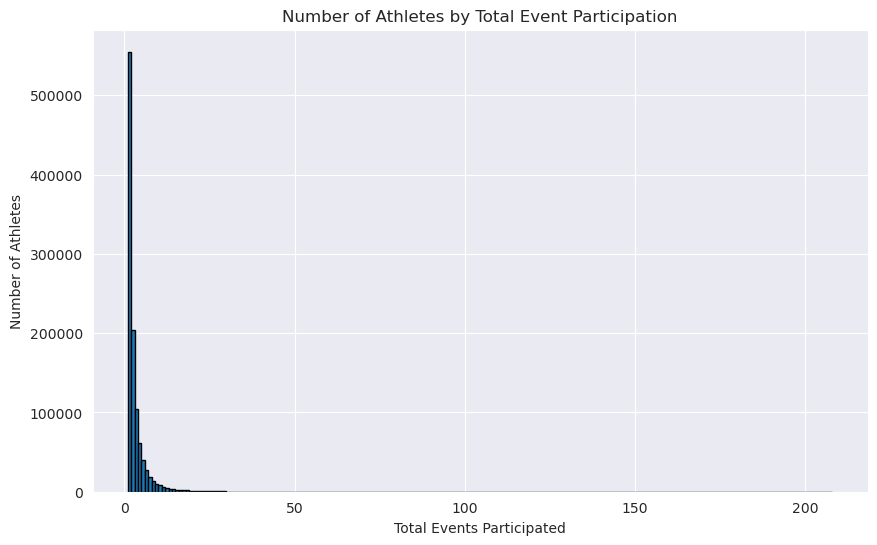

In [56]:
# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(athlete_event_counts['total_events'], bins=range(1, athlete_event_counts['total_events'].max() + 2), edgecolor='black')
plt.title('Number of Athletes by Total Event Participation')
plt.xlabel('Total Events Participated')
plt.ylabel('Number of Athletes')
#plt.yscale('log')  # Uses logarithmic scale for better visualization 
plt.grid(True)
plt.show()